In [8]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms.v2 as T
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("../")
from abus_classification.datasets import TDSCTumors2D

## Writing the dataset class

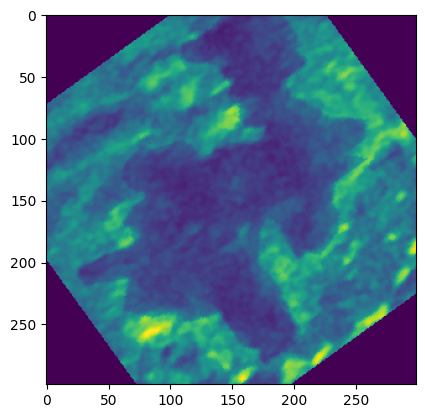

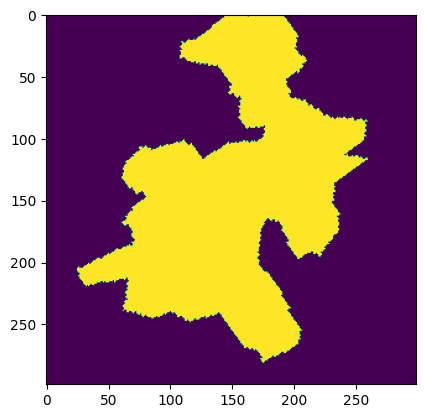

In [80]:
class ResizeTransformer:
    
    def __init__(self, size=(299,299)):
        self.transformer = T.Resize(size)
        
    def __call__(self, *inputs):
        outputs = []
        
        for i in inputs:
            i = Image.fromarray(i)
            outputs.append(self.transformer(i))
        
        return tuple(outputs)

class AnnotationTransformer:
    
    def __init__(self, alpha=.3):
        self.alpha = alpha
    
    def __call__(self, data, mask):
        
        return data-data*mask*self.alpha, mask
    
class AugmentationTransformer:
    
    def __init__(self):
        
        self.augmenter = T.Compose([
            T.RandomRotation(90),
            T.RandomHorizontalFlip(.5),  # Randomly flip the image horizontally
            T.RandomVerticalFlip(.5),
        ])
    
    
    def __call__(self, data, mask):
        data, mask = self.augmenter((data, mask))
        return data, mask
    
class ToTensor:
    
    def __init__(self):
        
        self.transformer = T.Compose([
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),         # Convert the image to a PyTorch tensor
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the image
        ])
    
    def __call__(self, data, mask):
        
        data = self.transformer(data)
        mask = self.transformer(mask)
        
        return data, mask
    

    
    
train_dataset = TDSCTumors2D(path="../data/tdsc/2d", train=True, transformers=[AnnotationTransformer(),ResizeTransformer(), AugmentationTransformer(), ToTensor()])
test_dataset = TDSCTumors2D(path="../data/tdsc/2d", train=False, transformers=[AnnotationTransformer(),ResizeTransformer(), ToTensor()])

x,m,y = train_dataset[10]

plt.imshow(x.permute((1,2,0)).numpy()[:,:,0])
plt.show()
plt.imshow(m.permute((1,2,0)).numpy()[:,:,0])
plt.show()

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

base_model = torchvision.models.inception_v3(weights=torchvision.models.inception.Inception_V3_Weights)
num_features = base_model.fc.in_features

base_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(.5),
    torch.nn.Linear(num_features, 2),
)

base_model.to(device)

# 3. Training loop
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)

data_loaders = { 
                "train": torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True),
                'test':  torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False),
            }

dataset_sizes = {
    "train": len(train_dataset),
    "test": len(test_dataset)
}


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in tqdm(range(num_epochs)):
        for phase in ['train', 'test']:
            if phase == 'train':
                base_model.train()
            else:
                base_model.eval()

            running_loss = 0.0
            running_corrects = 0

            for x, _, y in data_loaders[phase]:
                x = x.cuda() if torch.cuda.is_available() else x
                y = y.type(torch.float32).cuda() if torch.cuda.is_available() else y.type(torch.float32)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = 0
                    if phase == 'test':
                        outputs = base_model(x)
                    else:
                        outputs, _ = base_model(x) 
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(preds, y)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * x.size(0)
                running_corrects += torch.sum(preds == y.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# 4. Train the model
train_model(base_model, criterion, optimizer, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: "host_softmax" not implemented for 'Long'